In [3]:
# magic lines that avoid re-start 

import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

Path_NiallDMA = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC


Text(0, 0.5, 'Elely need / tot pore %')

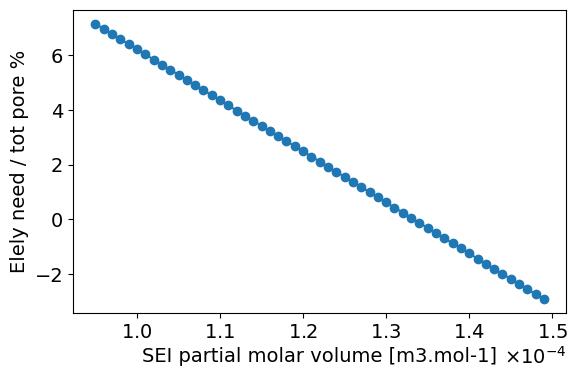

In [10]:
# debug dry-out rate:
def Dryout_Rate(VmolEC):
    #VmolEC    = 6.667e-05
    VmolSEI   = 9.585e-05
    VmolLiP   = 1.3e-05
    # for 1 mol LLI to SEI or something else:
    LLINegSEI = 1; LLINegSEIcr = 1; LLINegDeadLiP = 0; LLINegLiP  = 0

    Vol_EC_consumed  =  ( LLINegSEI + LLINegSEIcr + LLINegDeadLiP  ) * 2 * VmolEC    
    # Mark: Ruihe add LLINegDeadLiP, either with 2 or not, 
    # will decide how fast electrolyte being consumed!

    Vol_SEILiP_increase = 1.0*(
        (LLINegSEI+LLINegSEIcr) * VmolSEI 
        + LLINegLiP * VmolLiP)    #  volume increase due to SEI+total LiP 
    # Test_V = Vol_SEILiP_increase - Vol_Pore_decrease 
    Vol_Elely_need   = Vol_EC_consumed - Vol_SEILiP_increase
    #print(VmolEC,Vol_Elely_need)
    # assumem 0.25Ah capacity loss, total pore volume is ~5mL
    vol_pore_tot = 5 # mL
    consum_percen = 0.25*1/26.801* (Vol_Elely_need*1E6) /2/vol_pore_tot*100
    return Vol_Elely_need,consum_percen
def Dryout_Rate_SEI(VmolSEI):
    VmolEC    = 6.667e-05
    #VmolSEI   = 9.585e-05
    VmolLiP   = 1.3e-05
    # for 1 mol LLI to SEI or something else:
    LLINegSEI = 1; LLINegSEIcr = 1; LLINegDeadLiP = 0; LLINegLiP  = 0

    Vol_EC_consumed  =  ( LLINegSEI + LLINegSEIcr + LLINegDeadLiP  ) * 2 * VmolEC    
    # Mark: Ruihe add LLINegDeadLiP, either with 2 or not, 
    # will decide how fast electrolyte being consumed!

    Vol_SEILiP_increase = 1.0*(
        (LLINegSEI+LLINegSEIcr) * VmolSEI 
        + LLINegLiP * VmolLiP)    #  volume increase due to SEI+total LiP 
    # Test_V = Vol_SEILiP_increase - Vol_Pore_decrease 
    Vol_Elely_need   = Vol_EC_consumed - Vol_SEILiP_increase
    #print(VmolEC,Vol_Elely_need)
    # assumem 0.25Ah capacity loss, total pore volume is ~5mL
    vol_pore_tot = 5 # mL
    consum_percen = 0.25*1/26.801* (Vol_Elely_need*1E6) /2/vol_pore_tot*100
    return Vol_Elely_need,consum_percen
fs=14;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Vol_Elely_need_all = []; Consum_p = []
VmolEC = np.arange(4.7925e-5,8e-05,5e-6)
VmolSEI= np.arange(9.5e-05,15e-05,1e-6)
""" for VmolEC_i in VmolEC:
    Vol_Elely_need_i,consum_percen = Dryout_Rate(VmolEC_i)
    Vol_Elely_need_all.append(Vol_Elely_need_i)
    Consum_p.append(consum_percen) """
for VmolSEI_i in VmolSEI:
    Vol_Elely_need_i,consum_percen = Dryout_Rate_SEI(VmolSEI_i)
    Vol_Elely_need_all.append(Vol_Elely_need_i)
    Consum_p.append(consum_percen)
fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
#ax.plot(VmolEC,Consum_p,"-o")
ax.plot(VmolSEI,Consum_p,"-o")
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#ax.set_xlabel('EC partial molar volume [m3.mol-1]')
ax.set_xlabel('SEI partial molar volume [m3.mol-1]')
ax.set_ylabel('Elely need / tot pore %')